In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

In [2]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' %x)
pd.set_option('display.width', 200)

Text Pre-Processing

In [5]:
#Load dataset
df = pd.read_csv('/content/kozmos.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [6]:
#Normalizing Case Folding
df['Review'] = df['Review'].str.lower()

In [20]:
#Punctuations
#Punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)

In [11]:
#Numbers
df['Review'] = df['Review'].str.replace('\d', '')

In [14]:
#Stopwords
import nltk
nltk.download('stopwords')

sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw ))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#Rarewords / Custom Words

sil = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [21]:
#Lemmatization
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Review'].head(10)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Review
0,happy
1,good quality material however panel mismatched
2,product fun bedroom windowsbr imagery bit stre...
3,lo unico que gustaria e que sean un poco ma la...
4,great bang buck cant believe quality material ...
5,look different photo
6,exactly looking for heavy material great price...
7,looking picture thought curtain would thinner ...
8,much whiter thought would wasnt really expecti...
9,curtain picture show 3rd set ambesonne curtain...


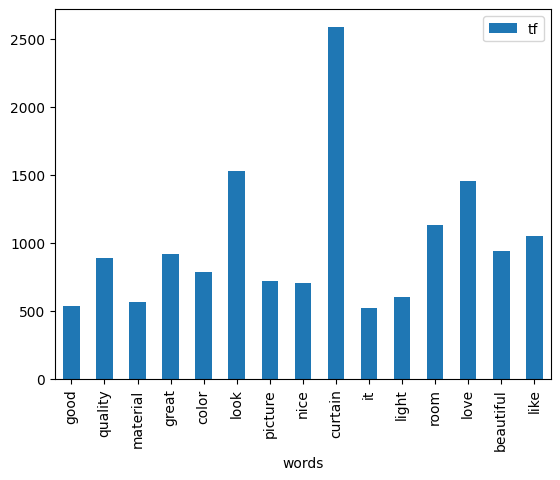

In [23]:
#Barplot

tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ['words', 'tf']
tf[tf['tf'] > 500].plot.bar(x='words', y='tf')
plt.show()

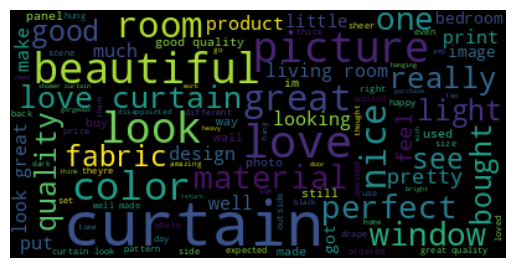

In [25]:
#WorldCloud

text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                        max_words=100,
                        background_color='black').generate(text)

plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [28]:
#Sentiment analysis
import nltk
nltk.download('vader_lexicon') # Download the VADER lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

#Step2
df['Review'][0:10].apply(lambda x: sia.polarity_scores(x))
df['Review'][0:10].apply(lambda x: sia.polarity_scores(x)['compound'])
df['Review'][0:10].apply(lambda x: 'pos' if sia.polarity_scores(x)['compound'] > 0 else 'neg')

df['Sentiment_Label'] = df['Review'].apply(lambda x: 'pos' if sia.polarity_scores(x)['compound'] > 0 else 'neg' )
df.groupby("Sentiment_Label")["Star"].mean()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Star
Sentiment_Label,
neg,3.41
pos,4.57


In [31]:
#Machine learning

train_x, train_y, test_x, test_y = train_test_split(df['Review'],
                                                   df['Sentiment_Label'],
                                                   random_state=42)

In [30]:
# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)


In [39]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

# Adım 2: Kurmuş olduğunuz model ile tahmin işlemleri gerçekleştiriniz.
        # a. Predict fonksiyonu ile test datasını tahmin ederek kaydediniz.
        # b. classification_report ile tahmin sonuçlarınızı raporlayıp gözlemleyiniz.
        # c. cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplayınız

y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()


ValueError: Found input variables with inconsistent numbers of samples: [4208, 3927]

In [41]:
#Machine learning

# Ensure train_x and train_y are derived from the same dataframe and have the same number of samples
train_x, test_x, train_y, test_y = train_test_split(df['Review'],
                                                   df['Sentiment_Label'],
                                                   random_state=42)

# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

              precision    recall  f1-score   support

         neg       0.31      0.91      0.46        75
         pos       0.99      0.89      0.94      1328

    accuracy                           0.89      1403
   macro avg       0.65      0.90      0.70      1403
weighted avg       0.96      0.89      0.91      1403



0.8574529740721912

In [42]:
random_review = pd.Series(df["Review"].sample(1).values)
new_comment = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  cool let surprising amount light in little much taste still nice 
 Prediction: ['pos']


In [43]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()




0.8959379766141332